# Introduction

### What is Deep Fake Voice?

Deep fake voice, also known as voice synthesis or AI-generated voice, is a type of artificial intelligence technology that can create convincing audio imitations of a person's voice. By leveraging advanced machine learning techniques, particularly deep learning, these systems analyze and replicate the nuances of human speech, including tone, pitch, accent, and speaking style. The resulting synthetic voices can be indistinguishable from real human voices to the untrained ear.

The process involves training models on large datasets of audio recordings of the target voice. Once the model is trained, it can generate new speech in the target voice based on any input text. This technology has advanced rapidly, making it possible to produce highly realistic and convincing audio that can mimic a specific individual.

### Why Do We Need to Detect Deep Fake Voice?

1.  **Security and Fraud Prevention**: Deep fake voices can be used to impersonate individuals for fraudulent activities. For example, criminals can use this technology to mimic the voice of a CEO or financial officer to authorize transactions or divulge sensitive information. Detecting deep fake voices is crucial to prevent such fraudulent activities and protect sensitive information.
    
2.  **Trust and Authenticity**: In an era where digital communication is prevalent, maintaining trust in audio communications is essential. Deep fake voices can be used to spread misinformation, conduct social engineering attacks, or create fake news, undermining trust in media and communications. Detection tools are necessary to verify the authenticity of audio content.
    
3.  **Privacy Protection**: Individuals' voices are a part of their personal identity. The unauthorized use of someone's voice through deep fake technology can lead to privacy breaches and exploitation. Detecting and preventing deep fake voices helps protect individuals' privacy and identity.
    
4.  **Legal and Ethical Concerns**: The misuse of deep fake voice technology can lead to legal issues, including defamation, identity theft, and intellectual property violations. Detecting deep fake voices can help enforce legal standards and ethical norms in digital communications.
    
5.  **Cybersecurity**: As voice-controlled systems and devices become more common, the ability to detect deep fake voices is critical to safeguard these systems from unauthorized access and control. Ensuring that voice commands are authentic helps protect against cyber threats.

## Import Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import librosa
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    LSTM,
    Bidirectional,
    Dropout,
    BatchNormalization,
    Dense,
    MaxPooling1D,
    concatenate,
    GlobalAveragePooling1D,
    Flatten,
)

from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import save_model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix, roc_curve

import seaborn as sns
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
np.random.seed(42)
tf.random.set_seed(42)


2024-07-10 05:47:28.909895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 05:47:28.910036: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 05:47:29.083630: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Exploratory Data Analysis (EDA)

In [2]:
data_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv"
df = pd.read_csv(data_path)
df.head()

,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE


The dataset contains processed features extracted from audio files.

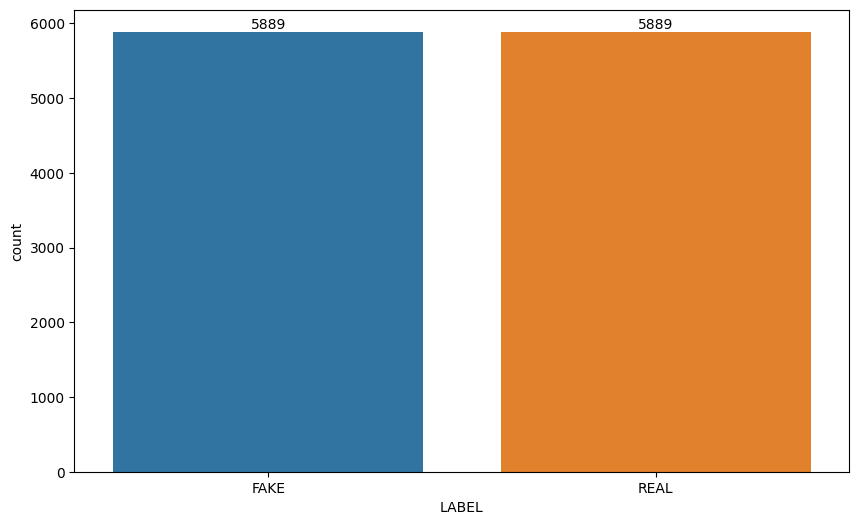

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='LABEL')

for p in plt.gca().patches:
    plt.text(p.get_x() + p.get_width() / 2, p.get_height() + 0.1, int(p.get_height()), 
             ha='center', va='bottom')

plt.show()

As we can see, the dataset is perfectly balanced with 5898 Fake and 5898 Real samples

## Label Encoding the Labels

In [4]:
label_encoder = LabelEncoder()
df['LABEL'] = label_encoder.fit_transform(df['LABEL'])

Putting the features and labels into variables X and y.

In [5]:
y = df['LABEL']
X = df.drop('LABEL', axis = 1)

## Visualizing Distribution of Features by Label

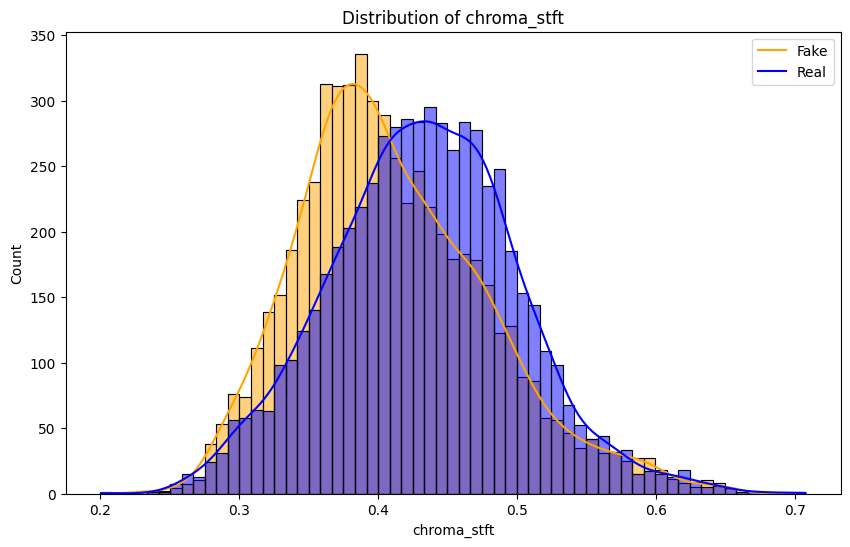

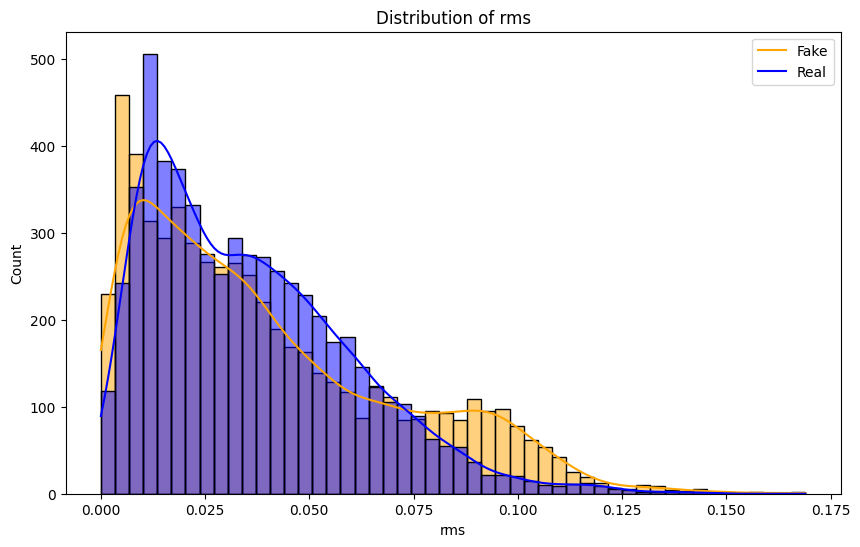

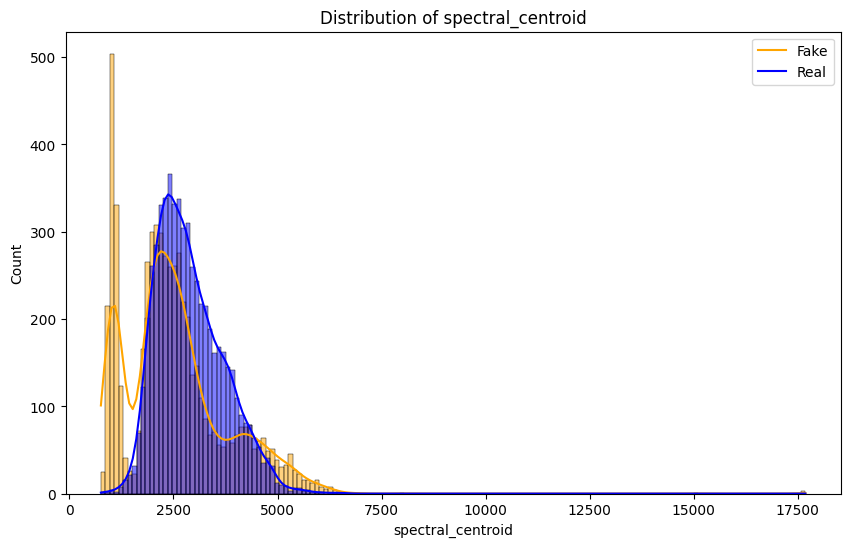

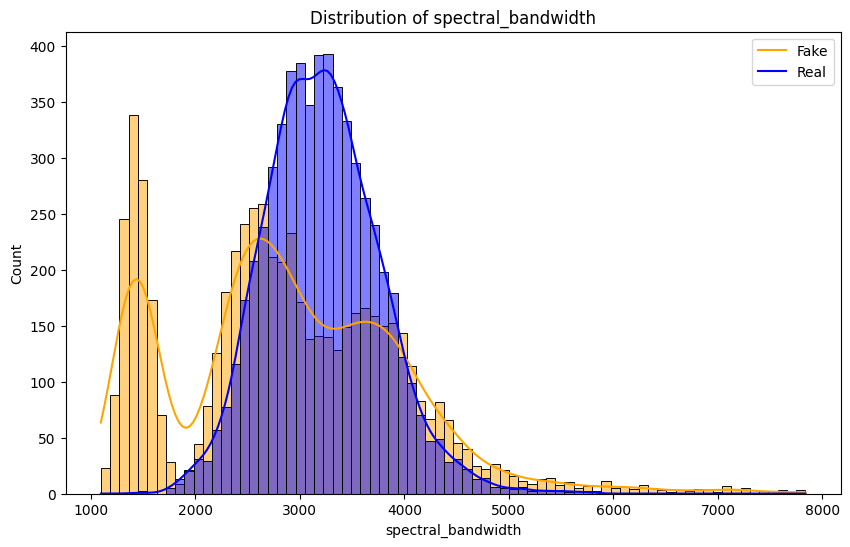

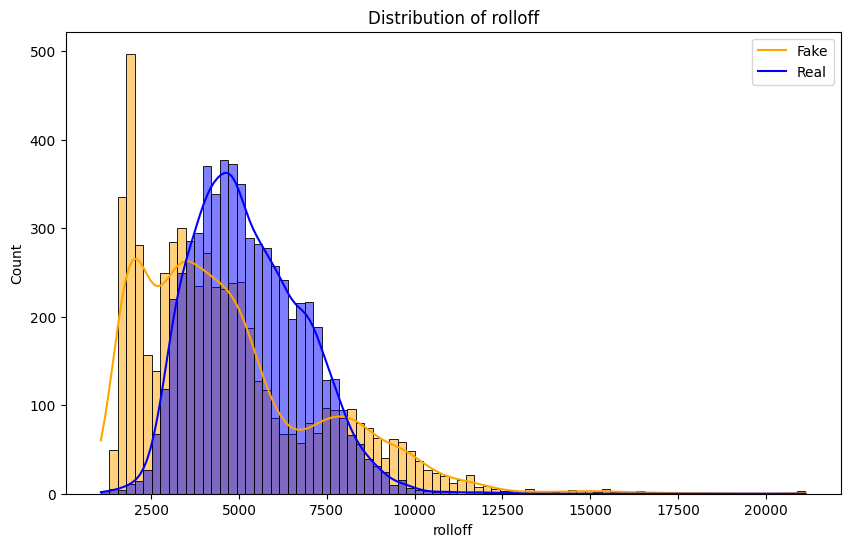

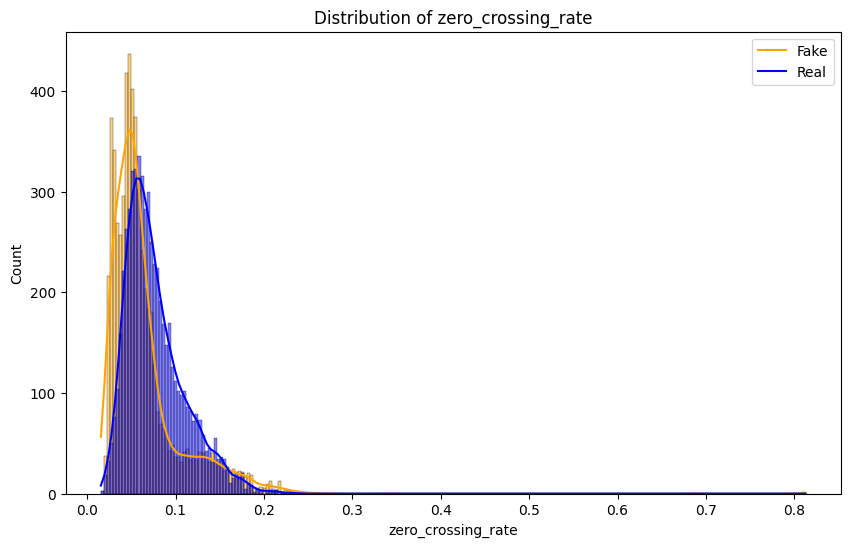

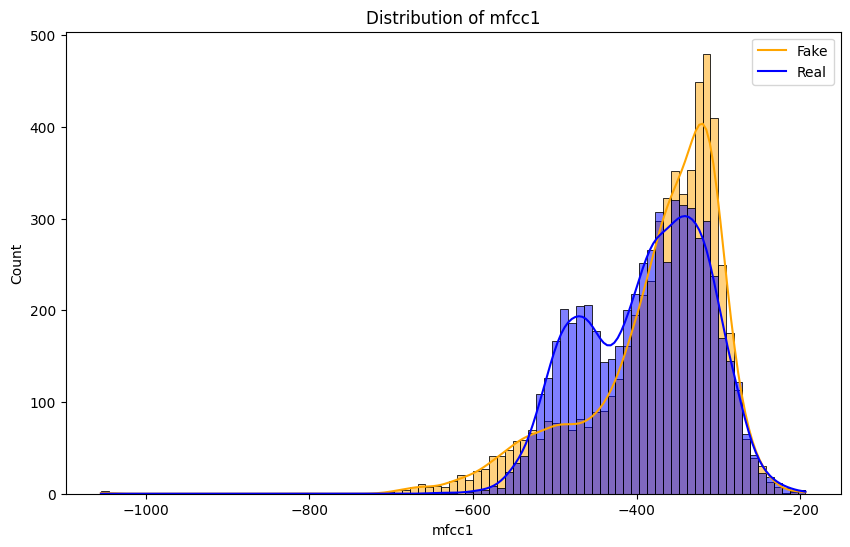

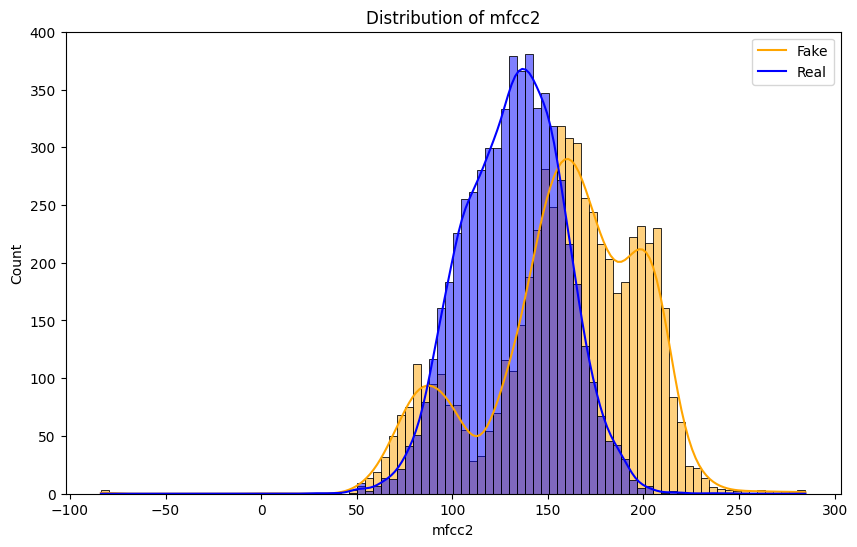

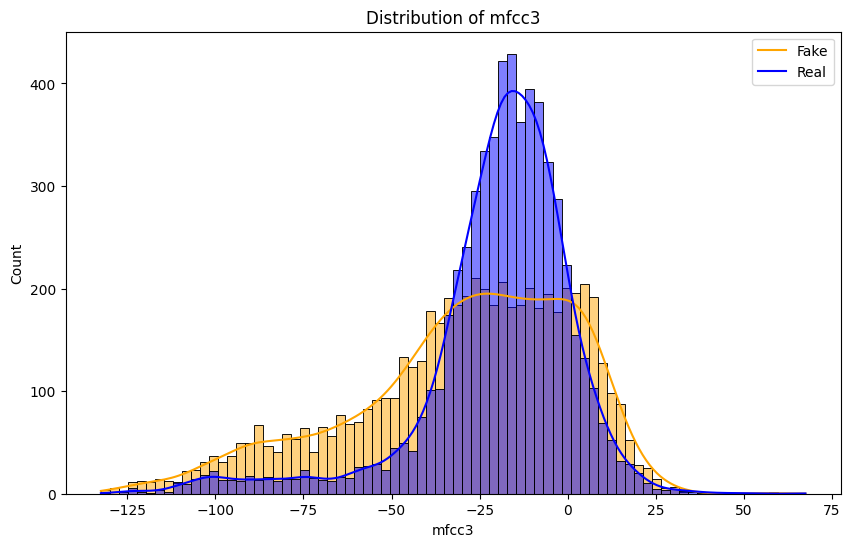

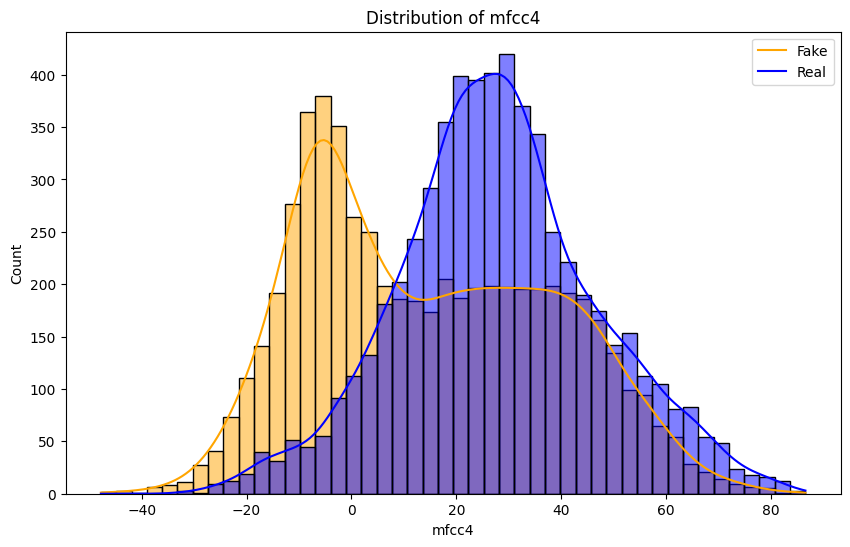

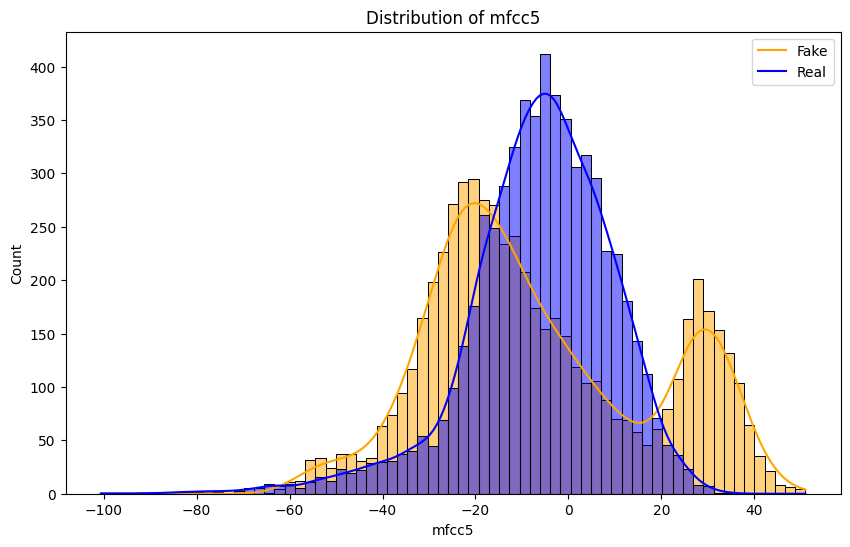

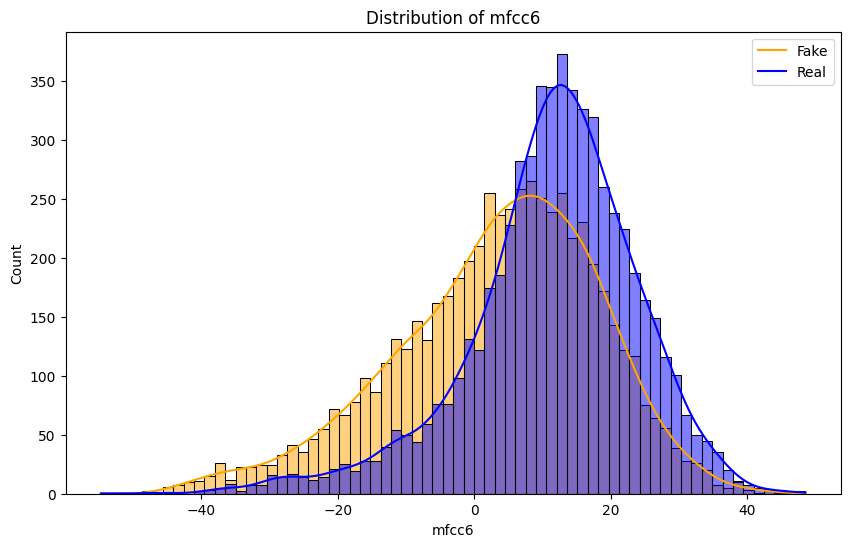

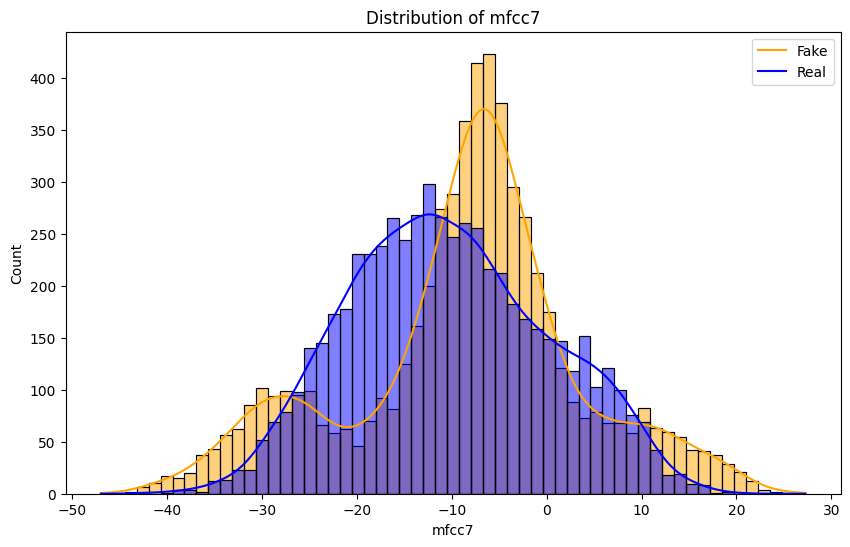

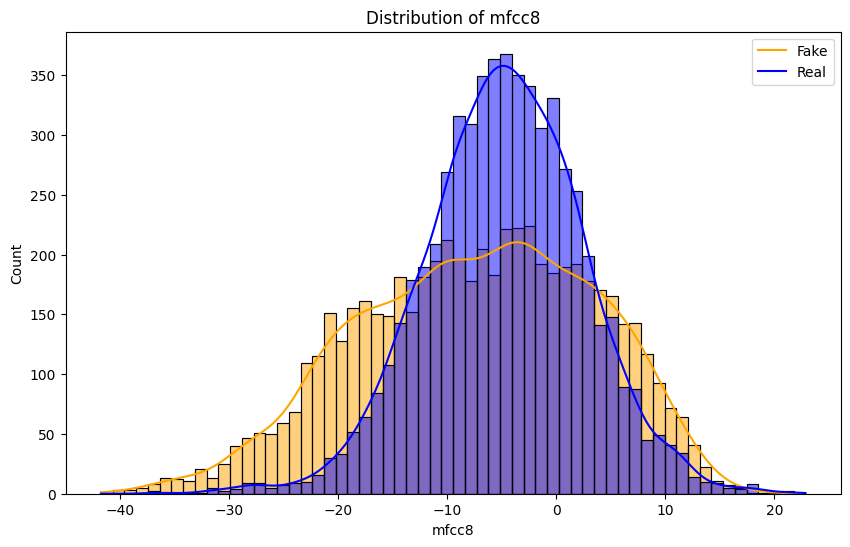

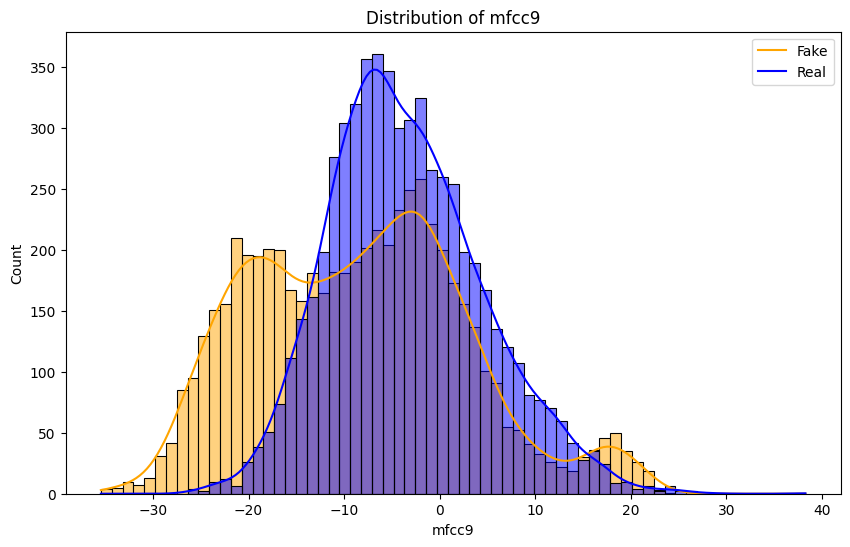

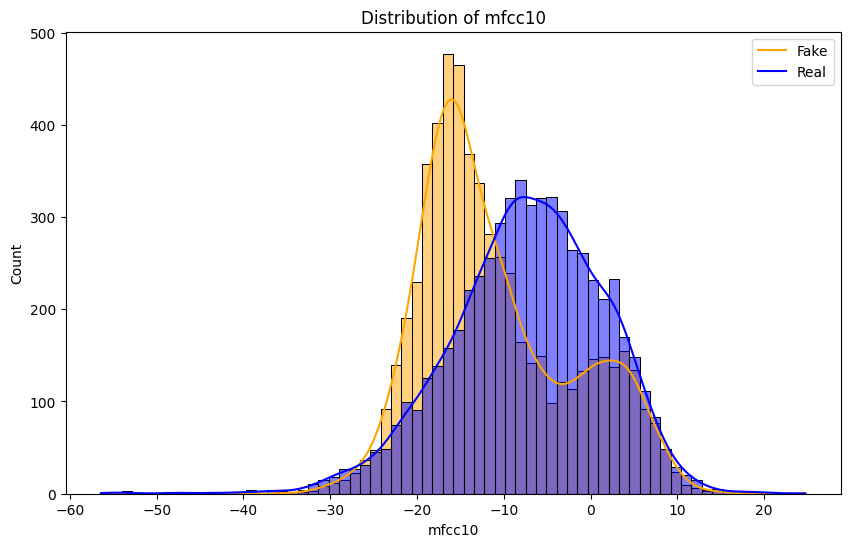

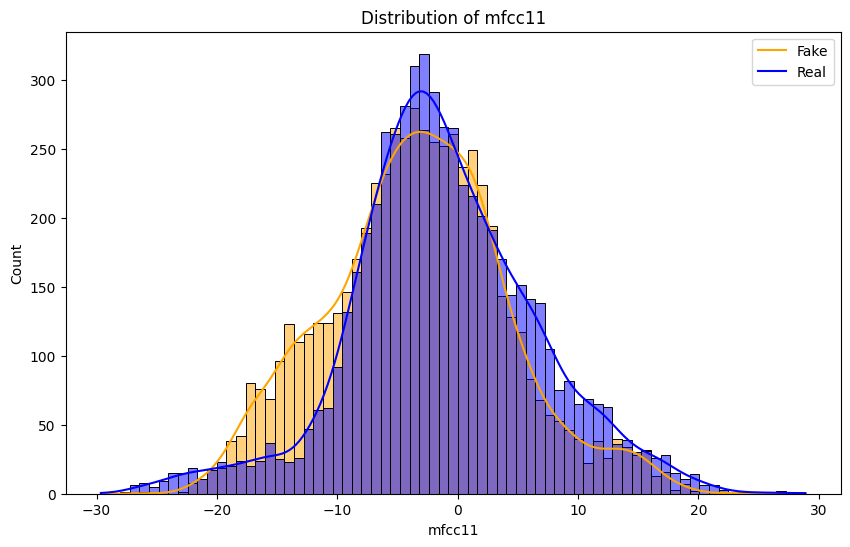

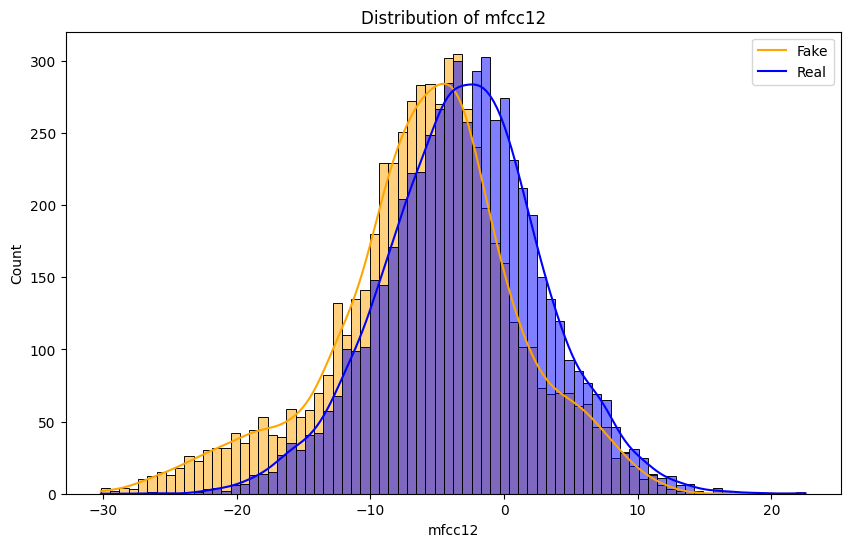

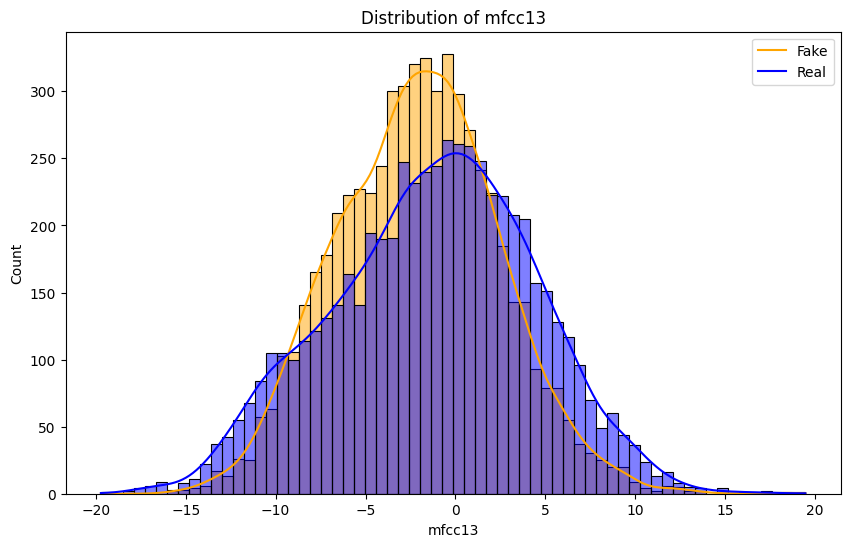

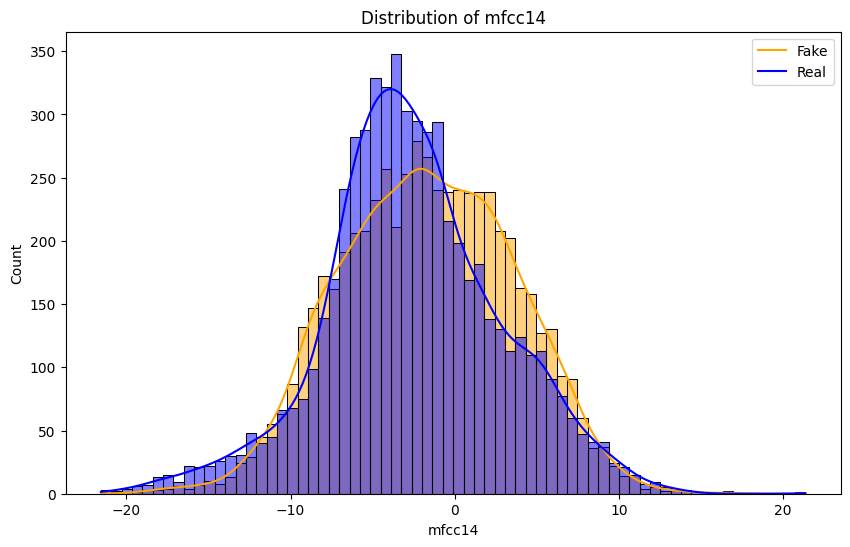

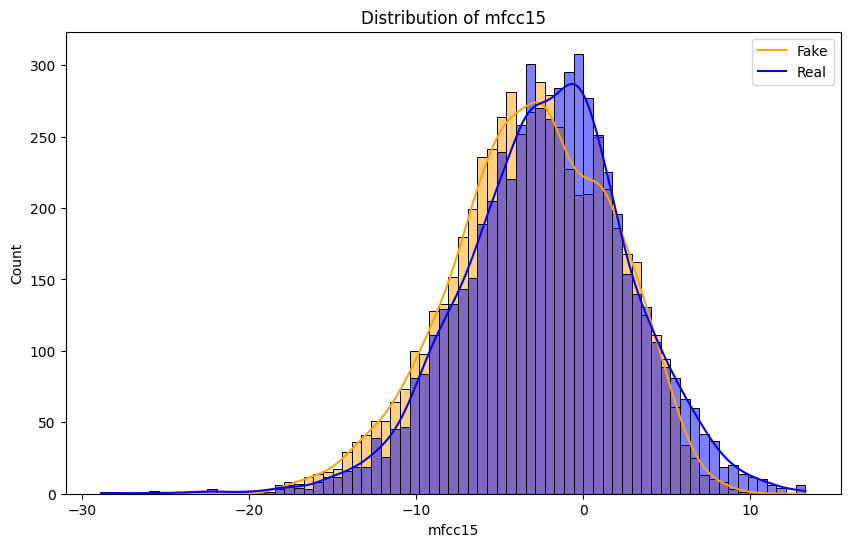

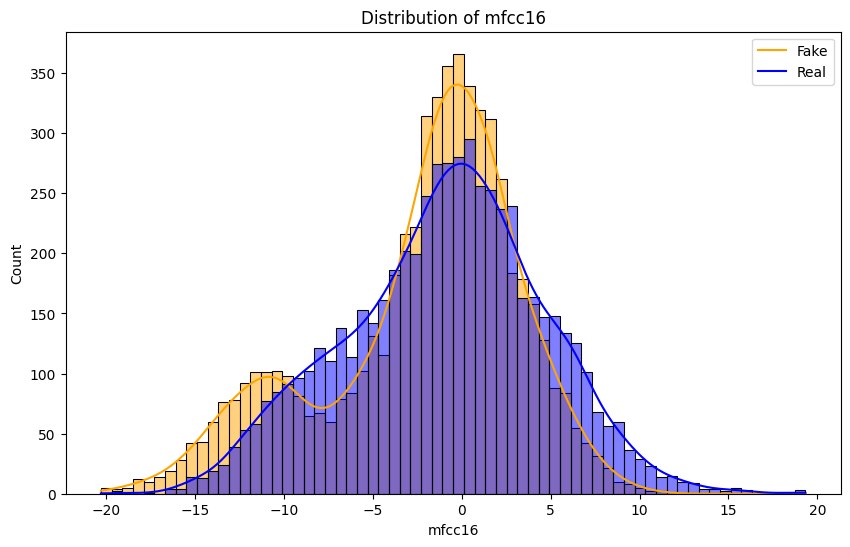

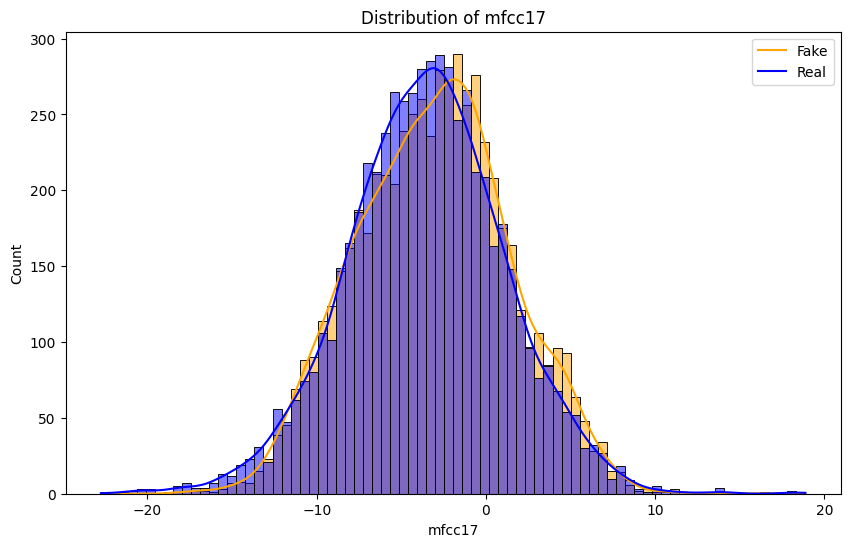

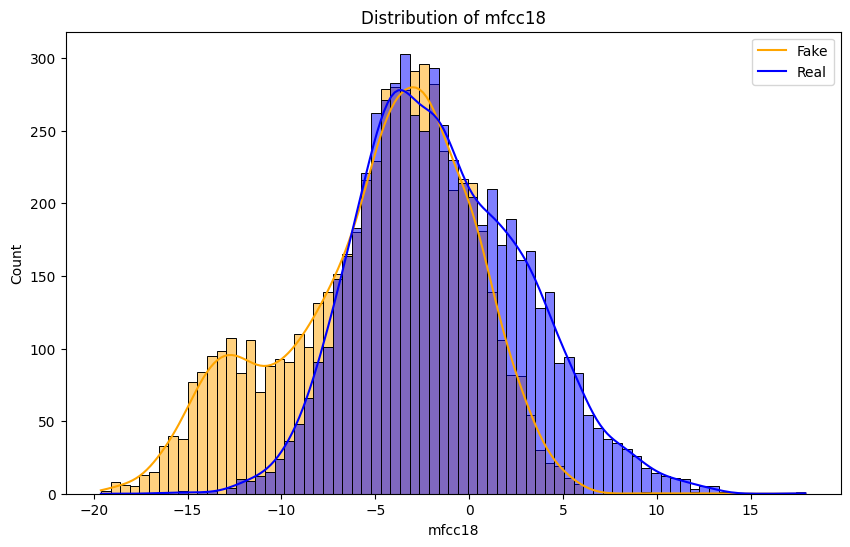

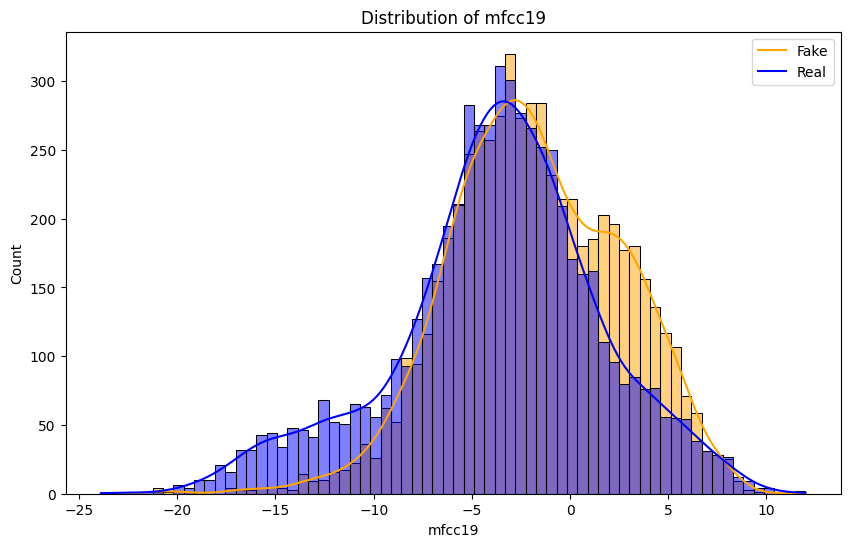

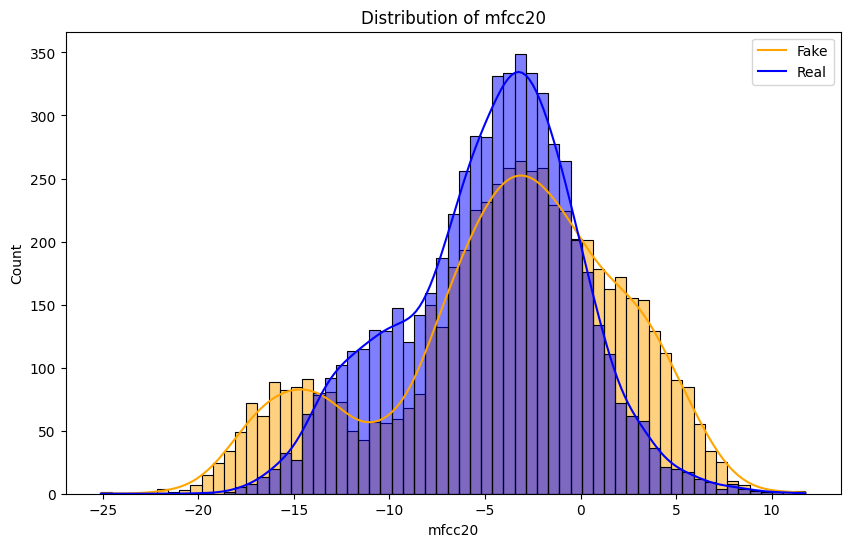

In [6]:
for column in X:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x=column, hue='LABEL', kde=True, palette=['blue', 'orange'])
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.legend(labels=['Fake', 'Real'])
    plt.show()

## Correlation  Matrix

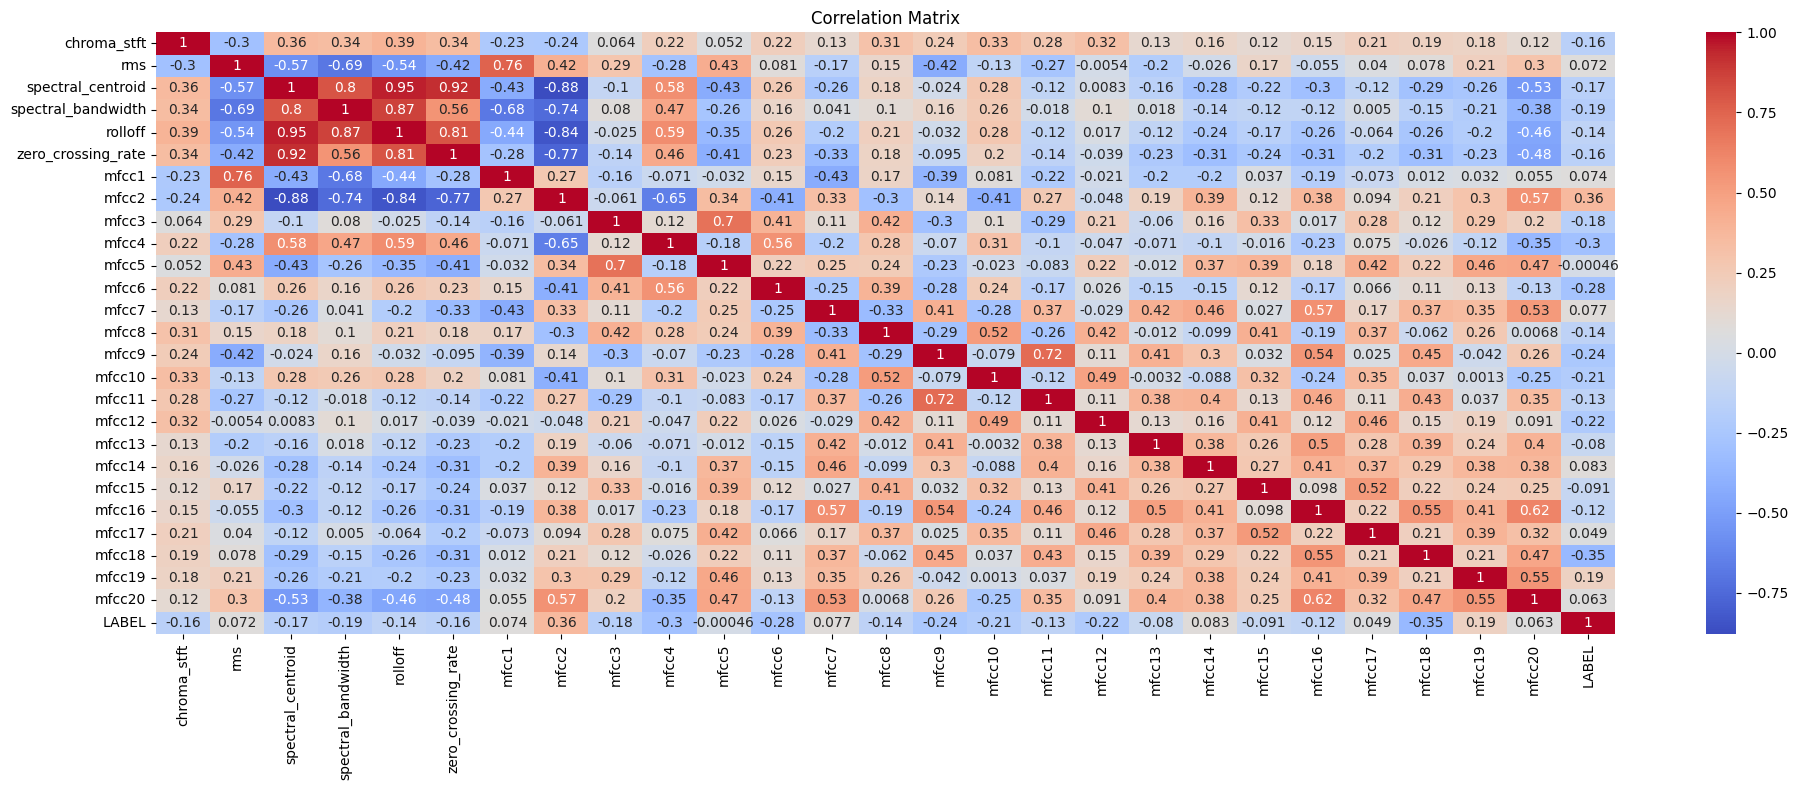

In [7]:
correlation_matrix = df.corr()
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# LSTM

## Preparing Data

In [8]:
def prepare_data(X, window_size = 10):
    
    data = []
    
    for i in range(len(X)):
        row = X.iloc[i].values
        row_data = []
        for j in range(len(row) - window_size):
            window = row[j : j + window_size]
            row_data.append(window)
        data.append(row_data)
        
    return np.array(data)

In [9]:
X.iloc[:, :] = MinMaxScaler().fit_transform(X)
new_X = prepare_data(X, window_size = 5)

## Train-Validation-Test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y.values, test_size=0.2, shuffle = True, stratify = y.values, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, stratify = y_train, random_state=42)

## Model Architecture

In [11]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

model = Sequential()

input_shape = (X_train.shape[1], X_train.shape[2])
model.add(Input(shape=input_shape))

# First LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Third LSTM layer
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))

# Fourth LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

# First Dense layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Second Dense layer
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 21, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 21, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 21, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,265 (481.50 KB)

 Trainable params: 123,265 (481.50 KB)

 Non-trainable params: 0 (0.00 B)

Creating a checkpoint to save the model with the best score.

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callback = [
    ModelCheckpoint(filepath='model.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, baseline=None, restore_best_weights=True, verbose=1)
]


## Train

In [13]:
history = model.fit(X_train, y_train, batch_size=32, epochs=60, validation_data = (X_val, y_val), callbacks = callback)

Epoch 1/60
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4861 - loss: 0.6938
Epoch 1: val_loss improved from inf to 0.68969, saving model to model.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4863 - loss: 0.6938 - val_accuracy: 0.5019 - val_loss: 0.6897
Epoch 2/60
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5799 - loss: 0.6714
Epoch 2: val_loss improved from 0.68969 to 0.56479, saving model to model.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.5801 - loss: 0.6712 - val_accuracy: 0.7141 - val_loss: 0.5648
Epoch 3/60
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6880 - loss: 0.6001
Epoch 3: val_loss improved from 0.56479 to 0.54442, saving model to model.keras
236/236 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.6881 - loss: 0.6000 - val_accuracy: 0.7666 - val_loss: 0.5444
Epoch 4/60
235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7136 - loss: 0.5755
Epoch 4: val_loss improved from 0.54442 to 0.46770, saving 

# Evaluation

## Loading Model

In [14]:
model = load_model('model.keras')

## Predict

In [15]:
%%time
y_pred = np.round(model.predict(X_test).flatten())

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
CPU times: user 3.26 s, sys: 244 ms, total: 3.5 s
Wall time: 2.24 s


## Metrics

In [16]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

In [17]:
print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.9609507640067911
F1 Score:  0.9609838846480068
Recall:  0.9617996604414262
Precision:  0.9601694915254237


## Confusion Matrix

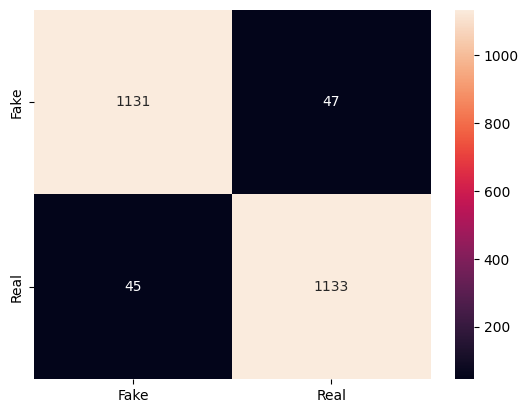

In [18]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, fmt='.4g')
ax.xaxis.set_ticklabels(['Fake', 'Real'])
ax.yaxis.set_ticklabels(['Fake', 'Real'])
plt.show()

## Accuracy and Loss Curve

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

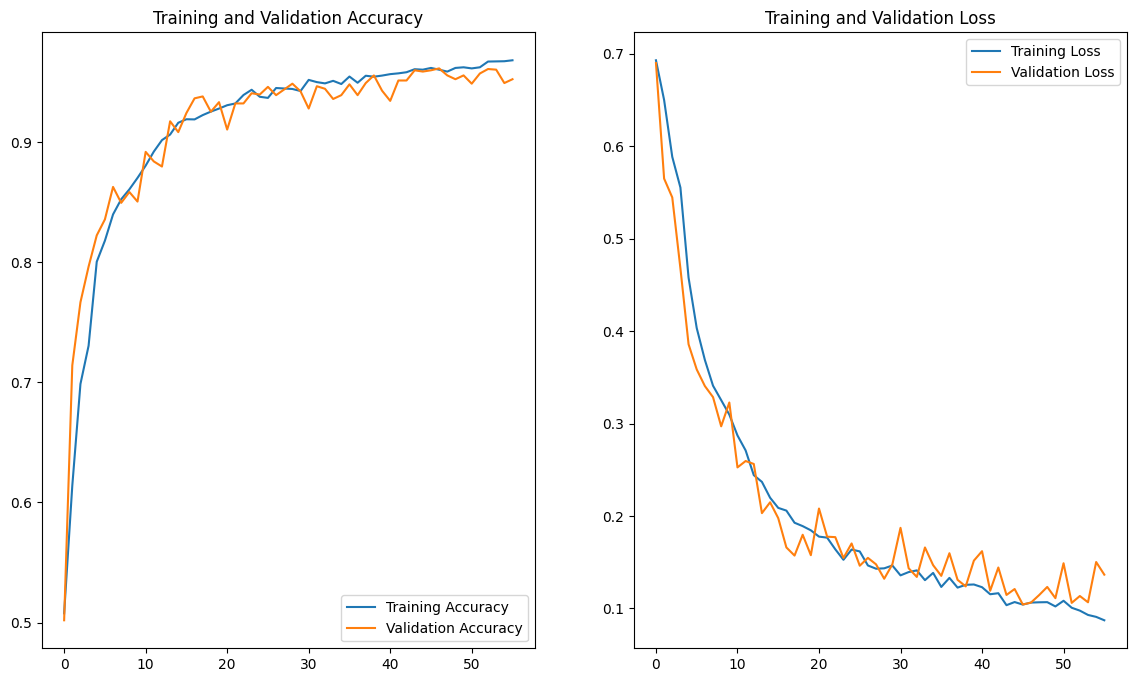

In [20]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
EPOCHS = len(acc)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Smoothed Curve

In [21]:
from scipy.ndimage import gaussian_filter1d

sacc = gaussian_filter1d(acc, sigma=2)
sval_acc = gaussian_filter1d(val_acc, sigma=2)

sloss = gaussian_filter1d(loss, sigma=2)
sval_loss = gaussian_filter1d(val_loss, sigma=2)

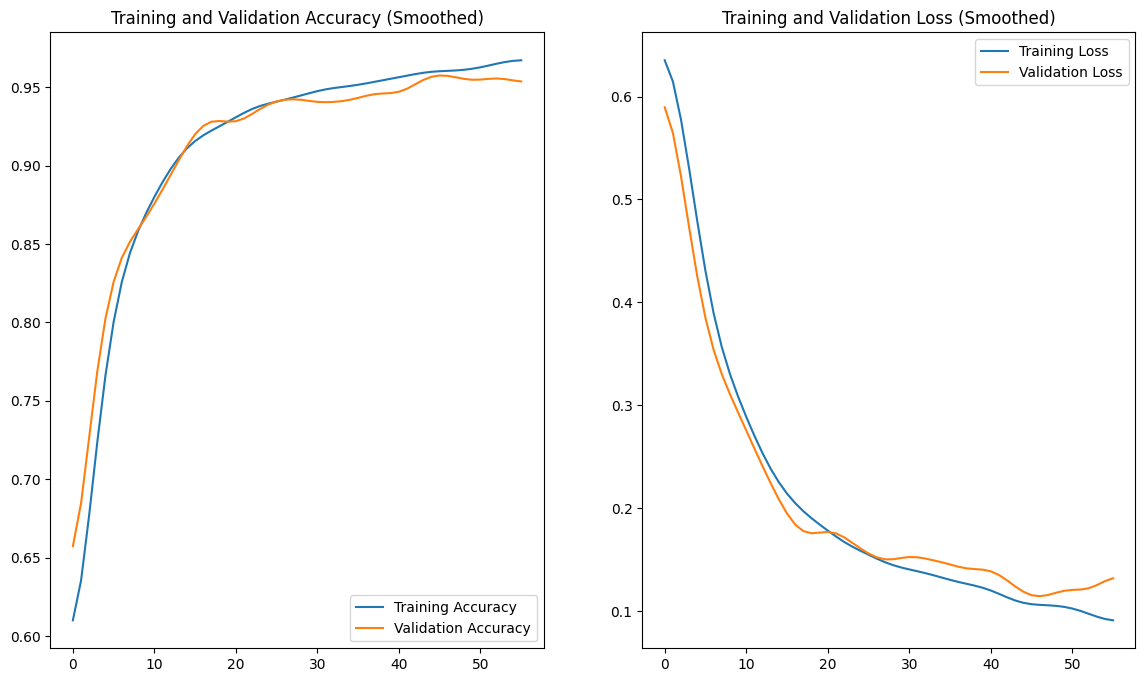

In [22]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), sacc, label='Training Accuracy')
plt.plot(range(EPOCHS), sval_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Smoothed)')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), sloss, label='Training Loss')
plt.plot(range(EPOCHS), sval_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Smoothed)')
plt.show()